# WORD2VEC

In [1]:
import collections
from collections import Counter
import math
import os
import errno
import random
import zipfile
import numpy as np
from six.moves import urllib
from six.moves import xrange 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir = "word2vec_data/words"
data_url = 'http://mattmahoney.net/dc/text8.zip'

# Download data
def fetch_words_data(url=data_url, words_data=data_dir):
    # Make the Dir if it does not exist
    os.makedirs(words_data, exist_ok=True)
    # Path to zip file 
    zip_path = os.path.join(words_data, "words.zip")
    # If the zip file isn't there, download it from the data url
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(url, zip_path)
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

# Use Defaults (this make take awhile!!)
words = fetch_words_data()
# Random slice of words
for w in words[9000:9014]:
    print(w,end=' ')

In [3]:
# Counter example
mylist = ["one",'one','two']
Counter(mylist).most_common(1)

[('one', 2)]

In [4]:
# Size of the bath
batch_size = 128

# Dimension of embedding vector
embedding_size = 150

# How many words to consider left and right (the bigger, the longer the training)
skip_window = 1       

# How many times to reuse an input to generate a label
num_skips = 2      

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

# Random set of words to evaluate similarity on.
valid_size = 16   

# Only pick dev samples in the head of the distribution.
valid_window = 100  
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
learning_rate = 0.01

# How many words in vocab
vocabulary_size = 50000

In [5]:
def create_counts(vocab_size=50000):
    # Begin adding vocab counts with Counter
    vocab = [] + Counter(words).most_common(vocab_size )
    # Turn into a numpy array
    vocab = np.array([word for word, _ in vocab])
    dictionary = {word: code for code, word in enumerate(vocab)}
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocab, dictionary


# This may take awhile
data,vocabulary,dictionary = create_counts(vocab_size=vocabulary_size)

In [6]:
data.shape

(17005207,)

In [7]:
(words[100],data[100])

('interpretations', 4186)

In [8]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels
data_index=0
batch, labels = generate_batch(8, 2, 1)

In [9]:
tf.reset_default_graph()
# Input data.
train_inputs = tf.placeholder(tf.int32, shape=[None])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [10]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [11]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal(
        [vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

In [12]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
# Add variable initializer.
init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
# Usually needs to be quite large to get good results, 
# training takes a long time!
num_steps = 5000
with tf.Session(config=tf.ConfigProto()) as sess:
    sess.run(init)
    average_loss = 0
    for step in range(num_steps):       
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}
        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        empty, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        if step % 1000 == 0:
            if step > 0:
                average_loss = average_loss / 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  250.98069763183594
Average loss at step  1000 :  11027.930868064881
Average loss at step  2000 :  21889.75742087555
Average loss at step  3000 :  25821.70193048096
Average loss at step  4000 :  32940.27200865174


In [14]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')


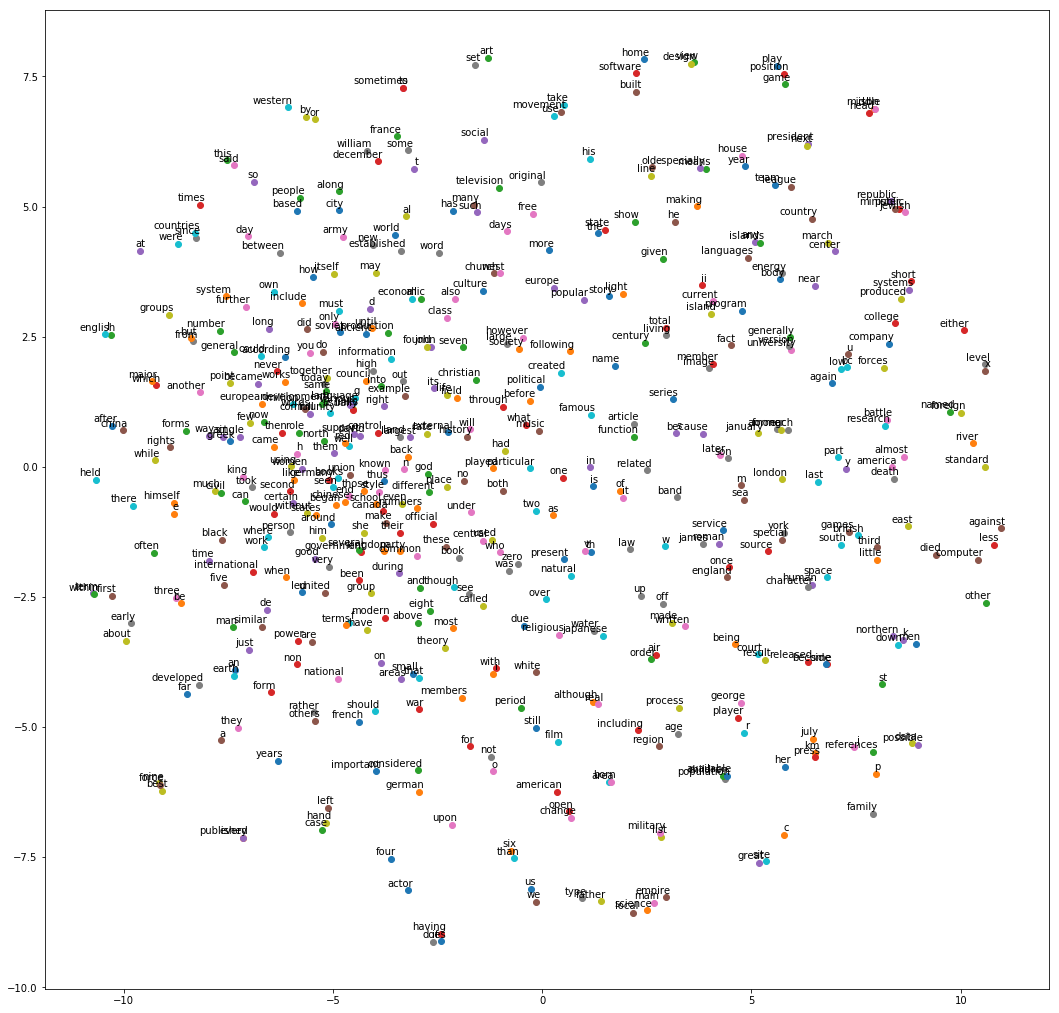

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

(-10, 10)

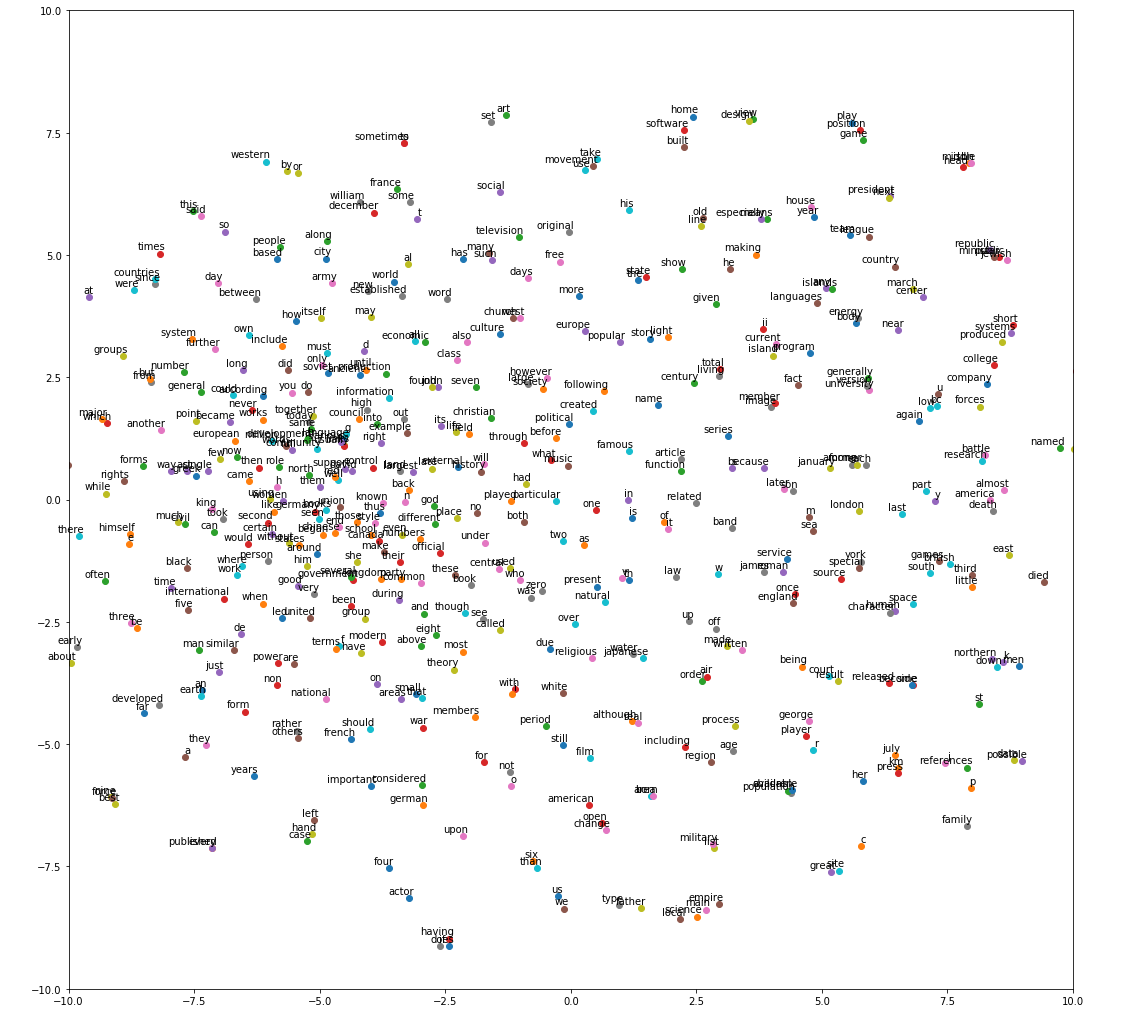

In [16]:
plot_with_labels(low_dim_embs, labels)
plt.xlim(-10,10)
plt.ylim(-10,10)